<a href="https://colab.research.google.com/github/anirudh-g/Msc-Data-science/blob/master/Object_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#SETUP

In [1]:
!pip3 install detecto

In [2]:
!pip install torch==1.4

     |████████████████████████████████| 753.4MB 20kB/s 
ERROR: torchvision 0.7.0+cu101 has requirement torch==1.6.0, but you'll have torch 1.4.0 which is incompatible.
  Found existing installation: torch 1.6.0+cu101
    Uninstalling torch-1.6.0+cu101:
      Successfully uninstalled torch-1.6.0+cu101


In [3]:
!pip install torchvision==0.5.0

     |████████████████████████████████| 4.0MB 5.7MB/s 
  Found existing installation: torchvision 0.7.0+cu101
    Uninstalling torchvision-0.7.0+cu101:
      Successfully uninstalled torchvision-0.7.0+cu101


In [4]:
!pip install bbox

In [5]:
from detecto import core, utils, visualize
import torch
import numpy as np
import random
import matplotlib.pyplot as plt
from torchvision import transforms
import pandas as pd
import numpy as np
import tensorflow as tf
import glob
from bbox import BBox2D, XYXY
import os
from PIL import Image

import xml.etree.ElementTree as ET
import torchvision.transforms.functional as FT

In [ ]:
print(torch.cuda.is_available())

True


In [6]:
import os
from google.colab import drive

drive.mount('/content/drive')
os.chdir('/content/drive/My Drive/Colab Notebooks/objection detection')

Mounted at /content/drive


#DATA PRE-PROCESSING

Create custom label mapping

In [ ]:
#Create custom label mapping
voc_labels = ('title', 'legend', 'axis label')
label_map = {k: v + 1 for v, k in enumerate(voc_labels)}
label_map['background']=0 #Assign 0 for background
print(label_map)

#Create reverse label maps
rev_label_map = {v: k for k, v in label_map.items()}

{'title': 1, 'legend': 2, 'axis label': 3, 'background': 0}


Convert list of labels to list of tensors (using custom label map)

In [ ]:
def label_to_tensor(label_list):
  #replace label name with custom integer map
  for x in label_list:
    for y in range(len(x)):
      x[y] = int(label_map[x[y]])
  
  #Convert nested list of labels to nested list of arrays (one array per image)
  for x in range(len(label_list)):
    label_list[x] = np.asarray(label_list[x])

  #Convert nested list of array to nested list of tensor (one tensor per image)
  for x in range(len(label_list)):
    label_list[x] = torch.from_numpy(label_list[x]).type(torch.LongTensor)
  
  return label_list

Convert any numeric list of lists to list of tensors

In [ ]:
def list_to_tensor(input_list):
  
  #Convert nested list of labels to nested list of arrays (one array per image)
  for x in range(len(input_list)):
    input_list[x] = np.asarray(input_list[x])

  #Convert nested list of array to nested list of tensor (one tensor per image)
  for x in range(len(input_list)):
    input_list[x] = torch.from_numpy(input_list[x])
  
  return input_list

Read ground truth XML to List of lists

In [ ]:
box_gt_list = []
label_gt_list =[]
difficult_gt_list =[]

# Loop through every XML file
for xml_file in glob.glob('/content/drive/My Drive/Colab Notebooks/objection detection/Validation' + '/*.xml'):
          tree = ET.parse(xml_file)
          root = tree.getroot()

          filename = root.find('filename').text
          objects = root.findall('object')
          
          # Each object represents each actual image label
          box_tmp =[]
          label_tmp =[]
          difficult_tmp=[]

          for member in objects:
              box = member.find('bndbox')
              row_1 = int(float(box[0].text)), int(float(box[1].text)), int(float(box[2].text)), int(float(box[3].text))
              box_tmp.append(list(row_1))
              
              label = member.find('name').text
              label_tmp.append(label)
              difficult = int(member.find('difficult').text)
              difficult_tmp.append(difficult)
        
              
          difficult_gt_list.append(difficult_tmp)
          label_gt_list.append(label_tmp)
          box_gt_list.append(box_tmp)

In [16]:
box_list = []
nb_title =0
nb_legend =0
nb_axis =0
small_title = 0
small_axis =0
small_legend =0
# Loop through every XML file
for xml_file in glob.glob('/content/drive/My Drive/Colab Notebooks/objection detection/Validation' + '/*.xml'):
          tree = ET.parse(xml_file)
          root = tree.getroot()

          objects = root.findall('object')
          size = root.find('size')
          width = int(size.find('width').text)
          height = int(size.find('height').text)
          img_area = width*height
        
          # Each object represents each actual image label

          for member in objects:
              
              label = member.find('name').text
              #print(label)
              box = member.find('bndbox')
              tmp = int(float(box[0].text)), int(float(box[1].text)), int(float(box[2].text)), int(float(box[3].text))
              if label == 'title':
                nb_title+=1
                box1 = BBox2D(list(tmp), mode=XYXY)
               # print(box1.height * box1.width)
                if ((box1.height * box1.width) <= (img_area * 0.32)):
                  small_title +=1
              
              if label == 'legend':
                nb_legend+=1
                box2 = BBox2D(list(tmp), mode=XYXY)
                if ((box2.height * box2.width) <= (img_area * 0.32)):
                  small_legend +=1
              
              if label == 'axis label':
                nb_axis+=1
                box3 = BBox2D(list(tmp), mode=XYXY)
                bb_area = (box3.height * box3.width)
                threshold = img_area * 0.32
                if bb_area <= threshold:
                  small_axis +=1
              
              
print("total no.of title instances ", nb_title)
print("Total no.of small objects (title) ", small_title)
print("total no.of legend instances ", nb_legend)
print("Total no.of small objects (legend) ",small_legend)
print("total no.of axis label instances ",nb_axis)
print("Total no.of small objects (axis label) ",small_axis)


total no.of title instances  93
Total no.of small objects (title)  93
total no.of legend instances  78
Total no.of small objects (legend)  78
total no.of axis label instances  108
Total no.of small objects (axis label)  108


In [ ]:
label_gt = label_to_tensor(label_gt_list)
print(label_gt)

[tensor([3, 3, 2]), tensor([1, 3, 2]), tensor([2, 3, 3]), tensor([1]), tensor([2]), tensor([1, 2, 3, 3]), tensor([1, 2]), tensor([1, 2, 3, 3]), tensor([1, 2]), tensor([2, 3, 3]), tensor([2, 3, 3]), tensor([1, 2]), tensor([1, 2]), tensor([1, 2, 3]), tensor([3, 3]), tensor([1, 2]), tensor([1, 3]), tensor([1, 2]), tensor([3, 3]), tensor([1]), tensor([1]), tensor([1, 2]), tensor([1, 2, 3]), tensor([1, 3]), tensor([3, 3]), tensor([2, 1]), tensor([1, 2]), tensor([3, 3]), tensor([1, 2, 3]), tensor([2]), tensor([1]), tensor([2, 3, 3]), tensor([1, 3]), tensor([1, 2, 3, 3]), tensor([3]), tensor([2, 3]), tensor([1, 3, 2]), tensor([1, 3, 2]), tensor([1, 2, 3]), tensor([1, 2]), tensor([1, 2, 3, 3]), tensor([1, 3]), tensor([1, 3]), tensor([1, 3]), tensor([1, 3]), tensor([1, 2, 3, 3]), tensor([1, 3, 3, 2]), tensor([1, 2]), tensor([1, 3, 3]), tensor([1, 3, 3]), tensor([1, 3, 3]), tensor([1]), tensor([1]), tensor([3, 3, 3]), tensor([2]), tensor([1]), tensor([1, 3, 3]), tensor([1, 3, 3]), tensor([1, 2])

In [ ]:
difficult_gt = list_to_tensor(difficult_gt_list)
print(difficult_gt)

[tensor([0, 0, 0]), tensor([0, 0, 0]), tensor([0, 0, 0]), tensor([0]), tensor([0]), tensor([0, 0, 0, 0]), tensor([0, 0]), tensor([0, 0, 0, 0]), tensor([0, 0]), tensor([0, 0, 0]), tensor([0, 0, 0]), tensor([0, 0]), tensor([0, 0]), tensor([0, 0, 0]), tensor([0, 0]), tensor([0, 0]), tensor([0, 0]), tensor([0, 0]), tensor([0, 0]), tensor([0]), tensor([0]), tensor([0, 0]), tensor([0, 0, 0]), tensor([0, 0]), tensor([0, 0]), tensor([0, 0]), tensor([0, 0]), tensor([0, 0]), tensor([0, 0, 0]), tensor([0]), tensor([0]), tensor([0, 0, 0]), tensor([0, 0]), tensor([0, 0, 0, 0]), tensor([0]), tensor([0, 0]), tensor([0, 0, 0]), tensor([0, 0, 0]), tensor([0, 0, 0]), tensor([0, 0]), tensor([0, 0, 0, 0]), tensor([0, 0]), tensor([0, 0]), tensor([0, 0]), tensor([0, 0]), tensor([0, 0, 0, 0]), tensor([0, 0, 0, 0]), tensor([0, 0]), tensor([0, 0, 0]), tensor([0, 0, 0]), tensor([0, 0, 0]), tensor([0]), tensor([0]), tensor([0, 0, 0]), tensor([0]), tensor([0]), tensor([0, 0, 0]), tensor([0, 0, 0]), tensor([0, 0])

In [ ]:
box_gt = list_to_tensor(box_gt_list)
print(box_gt)

[tensor([[  9,  46,  25,  90],
        [146, 139, 170, 155],
        [284,  51, 308, 115]]), tensor([[ 74,   2, 183,  12],
        [  3,  70,  12, 123],
        [ 60, 186, 200, 194]]), tensor([[207,   7, 245,  29],
        [110, 176, 135, 188],
        [  6,  71,  20,  99]]), tensor([[ 11,  16, 147,  32]]), tensor([[ 22, 168, 242, 183]]), tensor([[  4,   6, 102,  18],
        [109,  21, 195,  38],
        [  2,  79,  13, 111],
        [ 98, 158, 132, 165]]), tensor([[ 39,   7, 243,  23],
        [106, 166, 171, 179]]), tensor([[   8,   11,  340,   44],
        [  25,  100, 1061,  152],
        [ 528,  727,  699,  770],
        [   2,  375,   41,  497]]), tensor([[ 549,   57, 1058,  190],
        [  83,  765, 1549,  904]]), tensor([[ 78,  17, 336,  71],
        [  1, 115,  34, 340],
        [452, 455, 536, 479]]), tensor([[ 84,   4, 498,  40],
        [  6, 219,  30, 292],
        [379, 467, 504, 495]]), tensor([[ 89,   2, 300,  23],
        [140, 216, 253, 237]]), tensor([[ 66,  33, 46

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

Evaluation - Calculate mean average precision

In [ ]:
#Intersection and IoU from the tutorial: https://github.com/sgrvinod/a-PyTorch-Tutorial-to-Object-Detection
def find_intersection(set_1, set_2):
    """
    Find the intersection of every box combination between two sets of boxes that are in boundary coordinates.
    :param set_1: set 1, a tensor of dimensions (n1, 4)
    :param set_2: set 2, a tensor of dimensions (n2, 4)
    :return: intersection of each of the boxes in set 1 with respect to each of the boxes in set 2, a tensor of dimensions (n1, n2)
    """

    # PyTorch auto-broadcasts singleton dimensions
    lower_bounds = torch.max(set_1[:, :2].unsqueeze(1), set_2[:, :2].unsqueeze(0))  # (n1, n2, 2)
    upper_bounds = torch.min(set_1[:, 2:].unsqueeze(1), set_2[:, 2:].unsqueeze(0))  # (n1, n2, 2)
    intersection_dims = torch.clamp(upper_bounds - lower_bounds, min=0)  # (n1, n2, 2)
    return intersection_dims[:, :, 0] * intersection_dims[:, :, 1]  # (n1, n2)


def find_jaccard_overlap(set_1, set_2):
    """
    Find the Jaccard Overlap (IoU) of every box combination between two sets of boxes that are in boundary coordinates.
    :param set_1: set 1, a tensor of dimensions (n1, 4)
    :param set_2: set 2, a tensor of dimensions (n2, 4)
    :return: Jaccard Overlap of each of the boxes in set 1 with respect to each of the boxes in set 2, a tensor of dimensions (n1, n2)
    """

    # Find intersections
    intersection = find_intersection(set_1, set_2)  # (n1, n2)

    # Find areas of each box in both sets
    areas_set_1 = (set_1[:, 2] - set_1[:, 0]) * (set_1[:, 3] - set_1[:, 1])  # (n1)
    areas_set_2 = (set_2[:, 2] - set_2[:, 0]) * (set_2[:, 3] - set_2[:, 1])  # (n2)

    # Find the union
    # PyTorch auto-broadcasts singleton dimensions
    union = areas_set_1.unsqueeze(1) + areas_set_2.unsqueeze(0) - intersection  # (n1, n2)

    return intersection / union

In [ ]:
# MAP Calculation adapted from the tutorial https://github.com/sgrvinod/a-PyTorch-Tutorial-to-Object-Detection

def calculate_mAP(det_boxes, det_labels, det_scores, true_boxes, true_labels, true_difficulties):
    
    assert len(det_boxes) == len(det_labels) == len(det_scores) == len(true_boxes) == len(true_labels) == len(true_difficulties) 
    n_classes = len(label_map)

    # Store all (true) objects in a single continuous tensor while keeping track of the image it is from
    true_images = list()
    for i in range(len(true_labels)):
        true_images.extend([i] * true_labels[i].size(0))
    true_images = torch.LongTensor(true_images).to(device)  # (n_objects), n_objects is the total no. of objects across all images
    true_boxes = torch.cat(true_boxes, dim=0)  # (n_objects, 4)
    true_labels = torch.cat(true_labels, dim=0)  # (n_objects)
    true_difficulties = torch.cat(true_difficulties, dim=0)  # (n_objects)

    assert true_images.size(0) == true_boxes.size(0) == true_labels.size(0)

    # Store all detections in a single continuous tensor while keeping track of the image it is from
    det_images = list()
    for i in range(len(det_labels)):
        det_images.extend([i] * det_labels[i].size(0))
    det_images = torch.LongTensor(det_images).to(device)  # (n_detections)
    det_boxes = torch.cat(det_boxes, dim=0)  # (n_detections, 4)
    det_labels = torch.cat(det_labels, dim=0)  # (n_detections)
    det_scores = torch.cat(det_scores, dim=0)  # (n_detections)

    assert det_images.size(0) == det_boxes.size(0) == det_labels.size(0) == det_scores.size(0)

    # Calculate APs for each class (except background)
    average_precisions = torch.zeros((n_classes - 1), dtype=torch.float)  # (n_classes - 1)
    for c in range(1, n_classes):
        # Extract only objects with this class
        true_class_images = true_images[true_labels == c]  # (n_class_objects)
        true_class_boxes = true_boxes[true_labels == c]  # (n_class_objects, 4)
        true_class_difficulties = true_difficulties[true_labels == c]  # (n_class_objects)
        n_easy_class_objects = (1 - true_class_difficulties).sum().item()  # ignore difficult objects

        # Keep track of which true objects with this class have already been 'detected'
        # So far, none
        true_class_boxes_detected = torch.zeros((true_class_difficulties.size(0)), dtype=torch.uint8).to(device)  # (n_class_objects)

        # Extract only detections with this class
        det_class_images = det_images[det_labels == c]  # (n_class_detections)
        det_class_boxes = det_boxes[det_labels == c]  # (n_class_detections, 4)
        det_class_scores = det_scores[det_labels == c]  # (n_class_detections)
        n_class_detections = det_class_boxes.size(0)
        if n_class_detections == 0:
            continue

        # Sort detections in decreasing order of confidence/scores
        det_class_scores, sort_ind = torch.sort(det_class_scores, dim=0, descending=True)  # (n_class_detections)
        det_class_images = det_class_images[sort_ind]  # (n_class_detections)
        det_class_boxes = det_class_boxes[sort_ind]  # (n_class_detections, 4)

        # In the order of decreasing scores, check if true or false positive
        true_positives = torch.zeros((n_class_detections), dtype=torch.float).to(device)  # (n_class_detections)
        false_positives = torch.zeros((n_class_detections), dtype=torch.float).to(device)  # (n_class_detections)
        for d in range(n_class_detections):
            this_detection_box = det_class_boxes[d].unsqueeze(0)  # (1, 4)
            this_image = det_class_images[d]  # (), scalar

            # Find objects in the same image with this class, their difficulties, and whether they have been detected before
            object_boxes = true_class_boxes[true_class_images == this_image]  # (n_class_objects_in_img)
            object_difficulties = true_class_difficulties[true_class_images == this_image]  # (n_class_objects_in_img)
            # If no such object in this image, then the detection is a false positive
            if object_boxes.size(0) == 0:
                false_positives[d] = 1
                continue

            # Find maximum overlap of this detection with objects in this image of this class
            overlaps = find_jaccard_overlap(this_detection_box.type(torch.FloatTensor), object_boxes.type(torch.FloatTensor))  # (1, n_class_objects_in_img)
            max_overlap, ind = torch.max(overlaps.squeeze(0), dim=0)  # (), () - scalars

            # 'ind' is the index of the object in these image-level tensors 'object_boxes', 'object_difficulties'
            # In the original class-level tensors 'true_class_boxes', etc., 'ind' corresponds to object with index...
            original_ind = torch.LongTensor(range(true_class_boxes.size(0)))[true_class_images == this_image][ind]
            # We need 'original_ind' to update 'true_class_boxes_detected'

            # If the maximum overlap is greater than the threshold of 0.5, it's a match
            if max_overlap.item() > 0.5:
                # If the object it matched with is 'difficult', ignore it
                if object_difficulties[ind] == 0:
                    # If this object has already not been detected, it's a true positive
                    if true_class_boxes_detected[original_ind] == 0:
                        true_positives[d] = 1
                        true_class_boxes_detected[original_ind] = 1  # this object has now been detected/accounted for
                    # Otherwise, it's a false positive (since this object is already accounted for)
                    else:
                        false_positives[d] = 1
            # Otherwise, the detection occurs in a different location than the actual object, and is a false positive
            else:
                false_positives[d] = 1

        # Compute cumulative precision and recall at each detection in the order of decreasing scores
        cumul_true_positives = torch.cumsum(true_positives, dim=0)  # (n_class_detections)
        cumul_false_positives = torch.cumsum(false_positives, dim=0)  # (n_class_detections)
        cumul_precision = cumul_true_positives / (
                cumul_true_positives + cumul_false_positives + 1e-10)  # (n_class_detections)
        cumul_recall = cumul_true_positives / n_easy_class_objects  # (n_class_detections)

        # Find the mean of the maximum of the precisions corresponding to recalls above the threshold 't'
        recall_thresholds = torch.arange(start=0, end=1.1, step=.1).tolist()  # (11)
        precisions = torch.zeros((len(recall_thresholds)), dtype=torch.float).to(device)  # (11)
        for i, t in enumerate(recall_thresholds):
            recalls_above_t = cumul_recall >= t
            if recalls_above_t.any():
                precisions[i] = cumul_precision[recalls_above_t].max()
            else:
                precisions[i] = 0.
        average_precisions[c - 1] = precisions.mean()  # c is in [1, n_classes - 1]

    # Calculate Mean Average Precision (mAP)
    mean_average_precision = average_precisions.mean().item()

    # Keep class-wise average precisions in a dictionary
    average_precisions = {rev_label_map[c + 1]: v for c, v in enumerate(average_precisions.tolist())}

    return average_precisions, mean_average_precision

Read all images in the validation folder to a list

In [ ]:
images =[]
files = glob.glob('/content/drive/My Drive/Colab Notebooks/objection detection/Validation/*.jpg') + glob.glob('/content/drive/My Drive/Colab Notebooks/objection detection/Validation/*.jpeg') + glob.glob('/content/drive/My Drive/Colab Notebooks/objection detection/Validation/*.JPEG') + glob.glob('/content/drive/My Drive/Colab Notebooks/objection detection/Validation/*.JPG')
for img in files:
  image2 = utils.read_image(img)
  images.append(image2)

#OBJECT RECOGNITION

In [ ]:
#Gaussian noise function inspired from https://www.oreilly.com/library/view/programming-pytorch-for/9781492045342/ch04.html
class Noise():
    def __init__(self, mean, stddev):
        self.mean = mean
        self.stddev = stddev

    def __call__(self, img):
        self.stddev = np.random.exponential(self.stddev)
        noise = torch.zeros_like(img).normal_(self.mean, self.stddev)
        return img.add_(noise)

    def __repr__(self):
        repr = f"{self.__class__.__name__  }(mean={self.mean},stddev={self.stddev})"
        return repr

In [ ]:
transform_img = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize(800),
    transforms.ColorJitter(brightness=0.2),
    transforms.ToTensor(),
    Noise(mean=0.0, stddev=0.15), 
    utils.normalize_transform()
])

In [ ]:
dataset = core.Dataset('Train/', transform=transform_img)

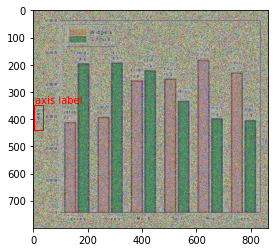

In [ ]:
image, targets = dataset[120]
visualize.show_labeled_image(image, targets['boxes'], targets['labels'])

In [ ]:
val_dataset = core.Dataset('Validation/')

Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth" to /root/.cache/torch/checkpoints/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth



Epoch 1 of 5
Loss: 0.17522386872079423
Epoch 2 of 5
Loss: 0.1503974361792474
Epoch 3 of 5
Loss: 0.1474751386671297
Epoch 4 of 5
Loss: 0.13272479835457057
Epoch 5 of 5
Loss: 0.131369684171933


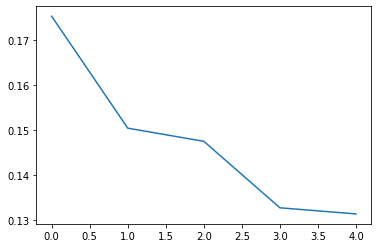

In [ ]:
model = core.Model(['title', 'legend', 'axis label'])

loader = core.DataLoader(dataset=dataset, shuffle=True)
losses = model.fit(loader, val_dataset, epochs=5, verbose=True, learning_rate=0.001)
plt.plot(losses)
plt.show()

In [ ]:
model.save('/content/drive/My Drive/Colab Notebooks/Obj det model noise/noise model.pth')

In [ ]:
model_noise = core.Model.load('/content/drive/My Drive/Colab Notebooks/Obj det model noise/noise model.pth', ['title', 'legend', 'axis label'])

In [ ]:
label_pr_list =[]
box_pr=[]
score_pr=[]
for image in images:
  pr = model_noise.predict(image)
  l, b, s = pr
  label_pr_list.append(l) # Nested list of labels (one list per image)
  box_pr.append(b)  # Nested list of tensors (one tensor per image)
  score_pr.append(s) # Nested list of tensors (one tensor per image)

In [ ]:
label_pr = label_to_tensor(label_pr_list)
print(label_pr)

[tensor([3, 1, 2, 2]), tensor([2, 3, 3, 2]), tensor([3, 2, 3, 1]), tensor([3, 2, 3, 2, 2, 2, 2, 2]), tensor([2, 1]), tensor([2, 1]), tensor([1, 3, 1, 2, 2, 3, 2]), tensor([1, 3, 1, 2, 2, 1, 2]), tensor([1, 1, 3, 2, 2, 3, 3, 2, 2, 2, 2, 1, 2, 2]), tensor([1, 3, 3, 2, 2, 2, 2, 1, 3, 3, 2]), tensor([3, 2, 3, 2, 2, 2, 2, 2, 1, 2, 1, 2, 1, 2, 2, 3, 2]), tensor([1, 3, 2, 2, 1, 2, 3, 3, 3, 3, 2]), tensor([1, 2, 3, 1, 1]), tensor([1]), tensor([1, 2, 1]), tensor([3, 3, 2]), tensor([3, 3, 3]), tensor([1, 2, 3]), tensor([1, 2, 1, 3, 3]), tensor([3, 1, 3, 3, 3, 3, 1, 1, 3]), tensor([1, 2, 2]), tensor([1, 3, 2, 1]), tensor([1, 3, 1, 2, 3]), tensor([1]), tensor([1, 2, 2, 2, 3, 2, 3, 2, 2, 3]), tensor([2, 1, 2, 2, 2]), tensor([2, 3, 3, 3, 3, 3, 3, 3]), tensor([1, 2, 3]), tensor([1, 3, 3, 3, 2, 3, 3, 3]), tensor([3, 3, 3, 3]), tensor([2, 3, 2, 3, 1, 2, 2]), tensor([1, 2, 3, 3, 1, 3, 3, 1, 2, 3]), tensor([3, 3, 3, 3, 3, 3, 2, 2, 1]), tensor([3, 1, 3, 3, 1, 1, 3]), tensor([1, 3, 2, 2, 1, 2, 2, 2, 1]), t

In [ ]:
ap, map = calculate_mAP(box_pr, label_pr, score_pr, box_gt, label_gt, difficult_gt)

mAP @ IoU > 0.5 

In [ ]:
print(map)

0.0162355899810791


In [ ]:
print(ap)

{'title': 0.019550342112779617, 'legend': 0.02006552182137966, 'axis label': 0.009090909734368324}


#ABLATION STUDY

# <H5>No noise, no data augmentation

In [ ]:
dataset2 = core.Dataset('Train/')

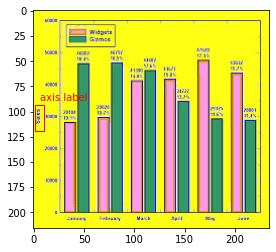

In [ ]:
image, targets = dataset2[120]
visualize.show_labeled_image(image, targets['boxes'], targets['labels'])

In [ ]:
val_dataset2 = core.Dataset('Validation/')

Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth" to /root/.cache/torch/checkpoints/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth



Epoch 1 of 5
Loss: 0.16032652806584125
Epoch 2 of 5
Loss: 0.1448807552002878
Epoch 3 of 5
Loss: 0.1353420084642787
Epoch 4 of 5
Loss: 0.13102427267512862
Epoch 5 of 5
Loss: 0.13047273123910563


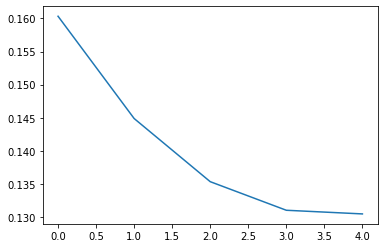

In [ ]:
model2 = core.Model(['title', 'legend', 'axis label'])

loader2 = core.DataLoader(dataset=dataset2, shuffle=True)
losses2 = model2.fit(loader2, val_dataset2, epochs=5, verbose=True, learning_rate=0.001)
plt.plot(losses2)
plt.show()

In [ ]:
model2.save('/content/drive/My Drive/Colab Notebooks/Obj det model noise/no_aug no_noise model.pth')

In [ ]:
ap, map = calculate_mAP(b, labels, s, b_gt, l_gt, diff_gt )

In [ ]:
vanilla_model = core.Model.load('/content/drive/My Drive/Colab Notebooks/Obj det model noise/no_aug no_noise model.pth', ['title', 'legend', 'axis label'])

In [ ]:
label_pr_list_2 =[]
box_pr_2=[]
score_pr_2=[]
for image in images:
  pr_2 = vanilla_model.predict(image)
  l2, b2, s2= pr_2
  label_pr_list_2.append(l2) # Nested list of labels (one list per image)
  box_pr_2.append(b2)  # Nested list of tensors (one tensor per image)
  score_pr_2.append(s2) # Nested list of tensors (one tensor per image)

In [ ]:
label_pr_2 = label_to_tensor(label_pr_list_2)
print(l_pr)

[tensor([1, 3, 2, 3, 3, 3, 3]), tensor([2, 3, 3]), tensor([2, 3, 3, 1, 3]), tensor([3, 2, 3, 2, 2, 2, 2, 3]), tensor([2, 2, 2, 2, 1, 2]), tensor([2, 1, 1, 1]), tensor([1, 3, 2, 2, 3, 2, 2, 2, 2, 1, 2, 2]), tensor([1, 3, 2, 2, 2]), tensor([2, 1, 2, 3, 2, 2, 3, 2, 2, 2]), tensor([1, 3, 2, 3, 2, 2, 2, 2, 2, 2, 3]), tensor([2, 2, 3, 3, 2, 2, 2, 2, 2, 1, 3]), tensor([2, 3, 2, 1, 1, 2, 1, 2, 2, 2, 3, 3, 3, 2, 2, 2]), tensor([1, 2, 3, 1, 1]), tensor([1]), tensor([1, 2, 1]), tensor([3, 3, 3]), tensor([3, 3, 3]), tensor([2, 1, 3, 3, 3, 3]), tensor([1, 2, 1, 2, 3, 1, 2, 1]), tensor([3, 1, 3, 3, 3, 3, 3, 1, 3, 3, 3, 3, 1]), tensor([1, 2, 3, 1]), tensor([1, 3, 2, 2]), tensor([1, 3, 3, 2]), tensor([1, 1]), tensor([2, 2, 2, 1, 2, 2, 2, 2, 3]), tensor([1, 2, 2, 2, 2]), tensor([2, 3, 2, 3, 3, 3, 3]), tensor([2, 1, 2, 2]), tensor([1, 3, 2, 3, 3, 3, 3, 3, 2]), tensor([3, 3, 3, 1, 3]), tensor([2, 2, 3, 1, 2, 3, 1]), tensor([1, 2, 2, 3, 2, 3, 2, 1, 2, 2, 3]), tensor([3, 3, 2, 3, 2, 3, 3, 1, 1, 3, 1, 3]), 

In [ ]:
ap2, map2 = calculate_mAP(box_pr_2, label_pr_2, score_pr_2, box_gt, label_gt, difficult_gt)

In [ ]:
print(map2)

0.009917556308209896


In [ ]:
print(ap2)

{'title': 0.009090909734368324, 'legend': 0.01482356060296297, 'axis label': 0.005838198587298393}


#<H4> keep data aug - remove noise

In [ ]:
transform_img2 = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize(800),
    transforms.ColorJitter(brightness=0.2),
    transforms.ToTensor(), 
    utils.normalize_transform()
])

In [ ]:
dataset3 = core.Dataset('Train/', transform=transform_img2)

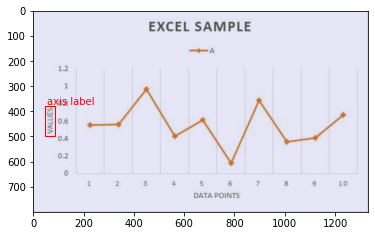

In [ ]:
image3, targets3 = dataset3[1000]
visualize.show_labeled_image(image3, targets3['boxes'], targets3['labels'])

In [ ]:
val_dataset3 = core.Dataset('Validation/')

Epoch 1 of 5
Loss: 0.16480964567765968
Epoch 2 of 5
Loss: 0.14786963121411406
Epoch 3 of 5
Loss: 0.13846899288636383
Epoch 4 of 5
Loss: 0.12859282619236403
Epoch 5 of 5
Loss: 0.13160438172679434


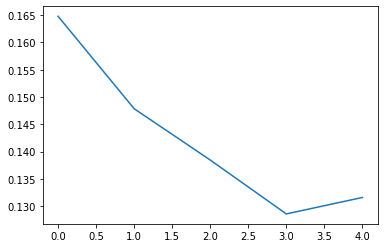

In [ ]:
model3 = core.Model(['title', 'legend', 'axis label'])

loader3 = core.DataLoader(dataset=dataset3, shuffle=True)
losses3 = model3.fit(loader3, val_dataset3, epochs=5, verbose=True, learning_rate=0.001)
plt.plot(losses3)
plt.show()

In [ ]:
model3.save('/content/drive/My Drive/Colab Notebooks/Obj det model noise/aug no_noise model.pth')

In [ ]:
aug_model = core.Model.load('/content/drive/My Drive/Colab Notebooks/Obj det model noise/aug no_noise model.pth', ['title', 'legend', 'axis label'])

Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth" to /root/.cache/torch/checkpoints/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth


In [ ]:
label_pr_list_3 =[]
box_pr_3=[]
score_pr_3=[]
for image in images:
  pr_3 = aug_model.predict(image)
  l3, b3, s3= pr_3
  label_pr_list_3.append(l3) # Nested list of labels (one list per image)
  box_pr_3.append(b3)  # Nested list of tensors (one tensor per image)
  score_pr_3.append(s3) # Nested list of tensors (one tensor per image)

In [ ]:
label_pr_3 = label_to_tensor(label_pr_list_3)
print(label_pr_3)

[tensor([1, 3, 2, 3, 3, 2]), tensor([2, 3, 3, 2]), tensor([2, 3, 3, 1, 2, 2, 2]), tensor([3, 3, 2, 2, 2]), tensor([2, 1, 3]), tensor([1, 2, 1]), tensor([3, 1, 1, 2, 3, 2, 2, 2, 2, 2]), tensor([1, 3, 1, 2, 1]), tensor([1, 3, 1, 3, 2, 1, 2, 3]), tensor([1, 3, 3, 2, 2, 2, 2]), tensor([3, 2, 3, 2, 1, 2, 1, 2, 1, 2, 2, 2, 2, 1, 1]), tensor([3, 2, 1, 2, 1, 1, 3, 3, 2, 3, 2, 3, 1, 2, 2]), tensor([1, 3, 2, 1]), tensor([1]), tensor([1, 2]), tensor([3, 3]), tensor([3, 3]), tensor([1, 2, 3]), tensor([1, 2, 3, 2]), tensor([3, 1, 1, 1, 3, 3, 2, 3, 3]), tensor([1, 2, 1]), tensor([1, 3, 2]), tensor([1, 3, 3, 2, 3, 1, 3, 3]), tensor([1]), tensor([1, 2, 2, 2]), tensor([1, 2, 2, 2]), tensor([2, 3, 3, 3, 3, 3]), tensor([2, 1, 2, 3]), tensor([1, 3, 3, 2, 3, 3, 1, 3, 3]), tensor([3, 3]), tensor([2, 3, 1, 2, 3, 2, 2]), tensor([1, 2, 3, 3, 1, 2]), tensor([3, 3, 3, 3, 3, 3]), tensor([3, 1, 3, 1, 1, 3, 3, 3, 1, 1, 1, 3]), tensor([1, 3, 2, 2, 3, 2, 2, 3, 1, 1, 2]), tensor([2, 1, 3, 2]), tensor([1, 2, 1, 2]), te

In [ ]:
ap3, map3 = calculate_mAP(box_pr_3, label_pr_3, score_pr_3, box_gt, label_gt, difficult_gt)

In [ ]:
print(map3)

0.010671828873455524


In [ ]:
print(ap3)

{'title': 0.008599509485065937, 'legend': 0.008264463394880295, 'axis label': 0.01515151560306549}


EXPERIMENTAL

In [ ]:
l3=[]
s3=[]
b3=[]
for image in images:
  pred3 = model2.predict(image)
  l2 =[]
  b2=[]
  s2=[]
  for l_loop, b_loop, s_loop in zip(*pred3):
    if s_loop > 0.5:
      l2.append(l_loop)
      b2.append(b_loop)
      s2.append(s_loop)
  l3.append(l2)
  s3.append(s2)
  b3.append(b2)

In [ ]:
s3 = [torch.cat(s) for s in s3]

In [ ]:
s3 = [torch.stack(s) if len(s) > 0 else None for s in s3]